In [1]:
from __future__ import absolute_import, division, print_function
from random import seed, randrange
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import shutil
import pickle
from datetime import datetime

In [2]:
# Setting GPU
tf.keras.backend.clear_session()
print("---------------------------------------------------------------------------------------------------------")
print("Tensorflow Version: ", tf.__version__)
print("---------------------------------------------------------------------------------------------------------")
print("Local devices")
print("---------------------------------------------------------------------------------------------------------")
print(device_lib.list_local_devices())
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("---------------------------------------------------------------------------------------------------------")
print("Local GPU")
print("---------------------------------------------------------------------------------------------------------")
print(physical_devices)

---------------------------------------------------------------------------------------------------------
Tensorflow Version:  2.1.0
---------------------------------------------------------------------------------------------------------
Local devices
---------------------------------------------------------------------------------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3417264315498052291
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2204421324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12509968972039222138
physical_device_desc: "device: 0, name: GeForce GTX 1060 3GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]
---------------------------------------------------------------------------------------------------------
Local GPU
---------------------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', devi

In [3]:
# variables
characters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
neurons_output = len(characters) #26
train_percentage = 0.8
test_percentage = train_percentage - 1
word_length = 6
# files
output_filename = "captchas.p"
# paths
path_to_images = "../assets/captchas-set1/"
path_to_image_file = path_to_images + "{}"
path_to_image_file_AERBLM = path_to_images + 'AERBLM.jpg'
path_to_output = "../out/"
path_output_filename = path_to_output + output_filename
# show data
print("softmax output number --> ",len(characters))
print("path_to_image_file    --> ",path_to_image_file)
print("path_output_filename  --> ",path_output_filename)

softmax output number -->  26
path_to_image_file    -->  ../assets/captchas-set2/{}
path_output_filename  -->  ../out/captchas.p


El caracter A esta en la posicion:  0
El caracter Z esta en la posicion:  25


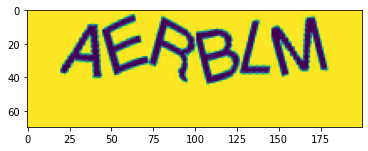

In [4]:
# load image
def load_train_image(filename):
  return load(filename, True)

def load_test_image(filename):
  return load(filename, False)

def load(filename, augment = True):
  inr = tf.io.read_file(filename)
  injpeg = tf.image.decode_jpeg(inr)
  inimg = tf.cast(injpeg, tf.float32)[..., :3]
  inimg = normalize(inimg)
  return inimg

def normalize(input_image):
  #input_image = (input_image / 127.5) - 1
  input_image = (input_image / 255)
  return input_image

def get_dir_content(path):
    if os.path.isdir(path):
        print("Getting content of <%s>" % path)
        return os.listdir(path)
    else:
        print("Path <%s> does not exist" % path)
        return []
        
def getCharacterPosition(character):
    for i in range(len(characters)):
        if character == characters[i]:
            return i
    return -1

def getCharacter(word_predicted):
  word = ''
  for i in range(len(word_predicted[0])):
      for j in range(len(characters)):
          if j == word_predicted[0][i]:
            word = word + characters[j]
  return word

def get_stack(p_word):
  internal_label = []
  for i in range(word_length):
    if len(internal_label) == 0: 
        result = getCharacterPosition(p_word[i])
        internal_label = np.append(internal_label, tf.one_hot(result, depth=neurons_output))
    else:
        result = getCharacterPosition(p_word[i])
        internal_label = np.vstack([internal_label, tf.one_hot(result, depth=neurons_output)])
  return internal_label

def fileAtLocation(path, filename):
    return os.path.exists(path + filename)

# --------------- testing funcions
# checking characters
result = getCharacterPosition('A')
print("El caracter A esta en la posicion: ", result)
result = getCharacterPosition('Z')
print("El caracter Z esta en la posicion: ", result)
# checkimages
in_fileimg = load_test_image(path_to_image_file_AERBLM)

# Pasarlo al rango de 0 a 1
in_fileimg = (in_fileimg + 1) / 2

# Mostrar ambas imagenes
plt.imshow(in_fileimg)
plt.show()

------------------ Load images and labels into arrays ---------------------

Getting content of <../assets/captchas-set2/>
array_images.len ........ -->  1000
array_images.shape ........ -->  (70, 200, 1)
array_labels.len ........ -->  1000
array_labels_readable.len -->  1000
array_labels -->  [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


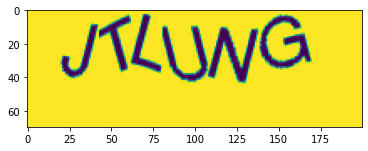

In [5]:
array_images = []
array_labels = []
array_labels_readable = []

files = get_dir_content(path_to_images)
for i in range(len(files)):
    input_file = files[i]
    # read image
    input_image = load_test_image(path_to_image_file.format(input_file))
    # read label
    word = os.path.splitext(input_file)[0]
    # convert label
    word_np = get_stack(word)
    # store into arrays
    array_images.append(input_image)
    array_labels.append(word_np)
    array_labels_readable.append(word)

test_index = 441
print("array_images.len ........ --> ", len(array_images))
print("array_images.shape ........ --> ", array_images[test_index].shape)
print("array_labels.len ........ --> ", len(array_labels))
print("array_labels_readable.len --> ", len(array_labels_readable))
print("array_labels --> ", array_labels[test_index])
plt.imshow(array_images[test_index])
plt.show()

train_images:  800
test_images:  200
train_labels:  800
test_labels:  200
image shape -->  (70, 200, 1)
image label -->  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


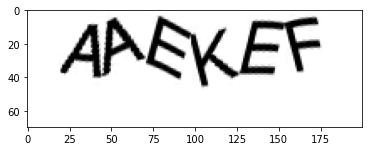

image shape -->  (70, 200, 1)
image label -->  [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]


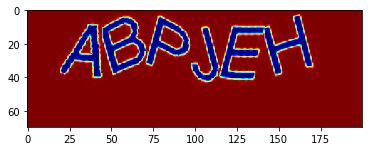

In [6]:
number_images = len(array_images)
train_size = int(number_images * train_percentage)
test_size = int(number_images * test_percentage)

array_images = np.array(array_images).astype('float')
array_labels = np.array(array_labels).astype('float')

train_images, test_images = array_images[:train_size, :], array_images[train_size:, :]
train_labels, test_labels = array_labels[:train_size], array_labels[train_size:]

print("train_images: ",len(train_images))
print("test_images: ",len(test_images))
print("train_labels: ",len(train_labels))
print("test_labels: ",len(test_labels))

# testing image 1
img1 = array_images[0]
print("image shape --> ", img1.shape)
print("image label --> ", array_labels[0])
plt.imshow(np.array(img1), cmap='gray')
plt.show()

# testing image 5
img1 = array_images[5]
print("image shape --> ", img1.shape)
print("image label --> ", array_labels[5])
plt.imshow(np.array(img1), cmap='jet')
plt.show()

In [7]:
model = tf.keras.models.Sequential(name='SequentialDigits')
# First convolution
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', input_shape=(70, 200, 1), name='1_conv2d_128_3_3'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
# Convolution
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', name='2_conv2d_256_3_3'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
# The fifth convolution
model.add(tf.keras.layers.Conv2D(512, (3,3), activation='relu', name='3_conv2d_512_3_3')),
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
# The fifth convolution
model.add(tf.keras.layers.Conv2D(1024, (3,3), activation='relu', name='4_conv2d_1024_3_3')),
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
# The 6 convolution
model.add(tf.keras.layers.Conv2D(1024, (2,2), activation='relu', name='5_conv2d_1024_3_3')),
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,1)))
model.add(tf.keras.layers.BatchNormalization())
# The fifth convolution
#model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu')),
#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
#model.add(tf.keras.layers.BatchNormalization())
# Reshaping to eight out values
#model.add(tf.keras.layers.Reshape(target_shape=(6, 3072), name='reshape'))
model.add(tf.keras.layers.Reshape(target_shape=(6, 1536), name='reshape'))
# 1024 neuron hidden layer
#model.add(tf.keras.layers.Dense(3072, activation='relu'))
#model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(1536, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(768, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(32, activation='relu'))
#model.add(tf.keras.layers.GRU(11, return_sequences=True, go_backwards=True, kernel_initializer='he_normal'))
model.add(tf.keras.layers.GRU(26, return_sequences=True, kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(26, activation='softmax'))
model.summary()

Model: "SequentialDigits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_conv2d_128_3_3 (Conv2D)    (None, 68, 198, 128)      1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 99, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 34, 99, 128)       512       
_________________________________________________________________
2_conv2d_256_3_3 (Conv2D)    (None, 32, 97, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 48, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 48, 256)       1024      
_________________________________________________________________
3_conv2d_512_3_3 (Conv2D)    (None, 14, 46, 512)  

In [8]:
# Optimizers
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
opt_rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
#opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

model.compile(loss = 'categorical_crossentropy', optimizer=opt_adam, metrics=['categorical_accuracy'])
#model.compile(loss = 'categorical_crossentropy', optimizer=opt_sgd, metrics=['categorical_accuracy'])
#model.compile(loss = 'categorical_crossentropy', optimizer=opt_rmsprop, metrics=['categorical_accuracy'])
history = model.fit(x=train_images, y=train_labels, validation_data=(test_images, test_labels), epochs=2000, batch_size = 60, verbose = 1, validation_steps=3)
#model.compile(loss = 'categorical_crossentropy', optimizer=opt_adam, metrics=['categorical_accuracy'])
#history = model.fit(images, epochs=20, steps_per_epoch=20, verbose = 1, validation_steps=3)
#history = model.fit(x=images, y=labels_array, epochs=10, batch_size = 100, verbose = 1, validation_steps=3)
#history = model.fit(x=images, y=labels_array, epochs=100, steps_per_epoch=128, validation_data=str_label)

model.save("../model/sequence_letters6.h5")

accuracy: 0.9992 - val_loss: 0.1580 - val_categorical_accuracy: 0.9843
Epoch 1828/2000
801/801 [==============================] - 5s 6ms/sample - loss: 0.0070 - categorical_accuracy: 0.9990 - val_loss: 0.1667 - val_categorical_accuracy: 0.9833
Epoch 1829/2000
801/801 [==============================] - 5s 6ms/sample - loss: 0.0055 - categorical_accuracy: 0.9994 - val_loss: 0.2213 - val_categorical_accuracy: 0.9787
Epoch 1830/2000
801/801 [==============================] - 5s 6ms/sample - loss: 0.0085 - categorical_accuracy: 0.9990 - val_loss: 0.1710 - val_categorical_accuracy: 0.9833
Epoch 1831/2000
801/801 [==============================] - 5s 6ms/sample - loss: 0.0055 - categorical_accuracy: 0.9992 - val_loss: 0.1693 - val_categorical_accuracy: 0.9833
Epoch 1832/2000
801/801 [==============================] - 5s 6ms/sample - loss: 0.0073 - categorical_accuracy: 0.9992 - val_loss: 0.1663 - val_categorical_accuracy: 0.9824
Epoch 1833/2000
801/801 [==============================] - 5s 6m

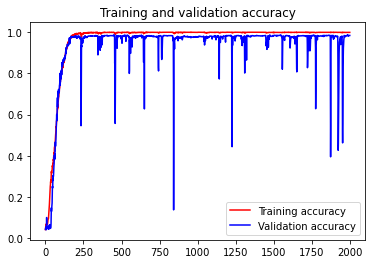

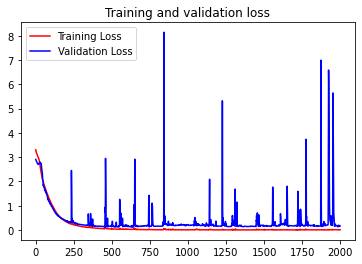

In [12]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
model = tf.keras.models.Sequential(name='SequentialDigits')
# First convolution
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(70, 200, 1), name='1_conv2d_128_3_3'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
# Convolution
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', name='2_conv2d_256_3_3'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
# The fifth convolution
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', name='3_conv2d_512_3_3')),
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
# The fifth convolution
model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu', name='4_conv2d_1024_3_3')),
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(tf.keras.layers.BatchNormalization())
# The 6 convolution
model.add(tf.keras.layers.Conv2D(256, (2,2), activation='relu', name='5_conv2d_1024_3_3')),
model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,1)))
model.add(tf.keras.layers.BatchNormalization())
# The fifth convolution
#model.add(tf.keras.layers.Conv2D(256, (3,3), activation='relu')),
#model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
#model.add(tf.keras.layers.BatchNormalization())
# Reshaping to eight out values
#model.add(tf.keras.layers.Reshape(target_shape=(6, 3072), name='reshape'))
model.add(tf.keras.layers.Reshape(target_shape=(6, 384), name='reshape'))
# 1024 neuron hidden layer
model.add(tf.keras.layers.Dense(384, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.3))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.4))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
#model.add(tf.keras.layers.GRU(11, return_sequences=True, go_backwards=True, kernel_initializer='he_normal'))
model.add(tf.keras.layers.GRU(26, return_sequences=True, kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dense(26, activation='softmax'))
model.summary()

Model: "SequentialDigits"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1_conv2d_128_3_3 (Conv2D)    (None, 68, 198, 32)       320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 34, 99, 32)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 34, 99, 32)        128       
_________________________________________________________________
2_conv2d_256_3_3 (Conv2D)    (None, 32, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 48, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 48, 64)        256       
_________________________________________________________________
3_conv2d_512_3_3 (Conv2D)    (None, 14, 46, 128)  

In [10]:
# Optimizers
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.9)
opt_rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
#opt_sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')

model.compile(loss = 'categorical_crossentropy', optimizer=opt_adam, metrics=['categorical_accuracy'])
#model.compile(loss = 'categorical_crossentropy', optimizer=opt_sgd, metrics=['categorical_accuracy'])
#model.compile(loss = 'categorical_crossentropy', optimizer=opt_rmsprop, metrics=['categorical_accuracy'])
history = model.fit(x=train_images, y=train_labels, validation_data=(test_images, test_labels), epochs=1500, batch_size = 100, verbose = 1)
#model.compile(loss = 'categorical_crossentropy', optimizer=opt_adam, metrics=['categorical_accuracy'])
#history = model.fit(images, epochs=20, steps_per_epoch=20, verbose = 1, validation_steps=3)
#history = model.fit(x=images, y=labels_array, epochs=10, batch_size = 100, verbose = 1, validation_steps=3)
#history = model.fit(x=images, y=labels_array, epochs=100, steps_per_epoch=128, validation_data=str_label)

model.save("../model/sequence_letters5.h5")

=========] - 0s 463us/sample - loss: 0.0385 - categorical_accuracy: 0.9942 - val_loss: 0.5143 - val_categorical_accuracy: 0.9192
Epoch 1147/1500
800/800 [==============================] - 0s 472us/sample - loss: 0.0543 - categorical_accuracy: 0.9887 - val_loss: 0.5097 - val_categorical_accuracy: 0.9142
Epoch 1148/1500
800/800 [==============================] - 0s 465us/sample - loss: 0.0452 - categorical_accuracy: 0.9910 - val_loss: 0.5005 - val_categorical_accuracy: 0.9167
Epoch 1149/1500
800/800 [==============================] - 0s 465us/sample - loss: 0.0453 - categorical_accuracy: 0.9902 - val_loss: 0.5058 - val_categorical_accuracy: 0.9167
Epoch 1150/1500
800/800 [==============================] - 0s 466us/sample - loss: 0.0437 - categorical_accuracy: 0.9910 - val_loss: 0.5205 - val_categorical_accuracy: 0.9083
Epoch 1151/1500
800/800 [==============================] - 0s 461us/sample - loss: 0.0504 - categorical_accuracy: 0.9885 - val_loss: 0.5038 - val_categorical_accuracy: 0.9

KeyboardInterrupt: 

In [ ]:
# Plot the chart for accuracy and loss on both training and validation
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [16]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing import image

model = tf.keras.models.load_model('../model/sequence_letters_98_v3.bueno.h5')
#model.summary()

filenameToCheck1 = '../assets/images-captchas-downloaded/captcha_aivcnoinor.jpg'

# predicting images
image_data = image.load_img(filenameToCheck1, target_size=(70, 200), color_mode='grayscale')
print(image_data)
filearray = image.img_to_array(image_data)
print(filearray.shape)
filearray = filearray/255
filearray = np.expand_dims(filearray, axis=0)
result = np.vstack([filearray])

<PIL.JpegImagePlugin.JpegImageFile image mode=L size=200x70 at 0x1E384806608>
(70, 200, 1)


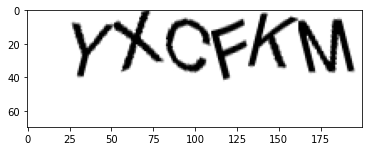

[[24 23  2  5 10 12]]
YXCFKM


In [17]:

plt.imshow(np.array(image_data), cmap='gray')
plt.show()

prediction = model.predict(result, batch_size=1)
# Generate arg maxes for predictions
classes = np.argmax(prediction, axis = 2)
print(classes)
characters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

array_word_predicted = getCharacter(classes)
print(array_word_predicted)


<PIL.JpegImagePlugin.JpegImageFile image mode=L size=200x70 at 0x1E97F5E3408>


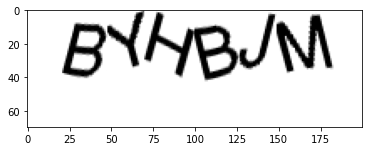

In [15]:
captcha_path = "../assets/captchas-set2/"
captcha_path_files = os.listdir(captcha_path)

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's prepare a random input image of a cat or dog from the training set.
captcha_files = [os.path.join(captcha_path, f) for f in captcha_path_files]

captcha_selected = random.choice(captcha_files)
img = load_img(captcha_selected, target_size=(70, 200), color_mode='grayscale') # this is a PIL image
print(img)
plt.imshow(np.array(img), cmap='gray')
plt.show()


C:\util\Anaconda3\envs\tensorflowgpu37\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\util\Anaconda3\envs\tensorflowgpu37\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


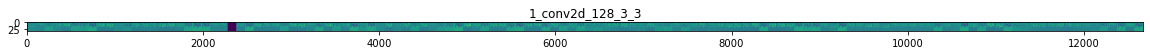

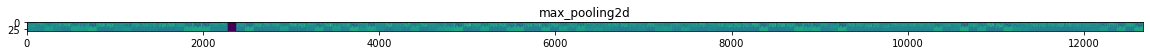

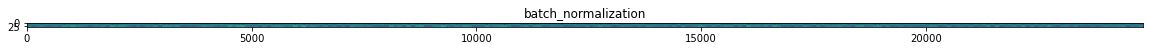

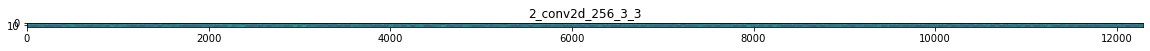

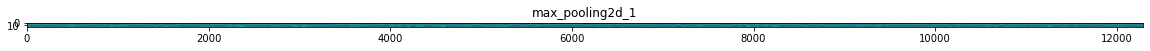

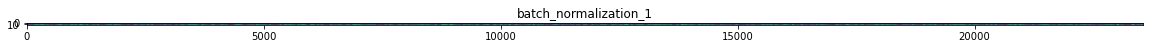

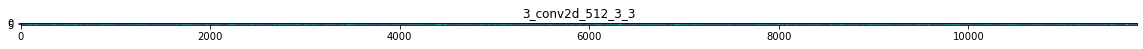

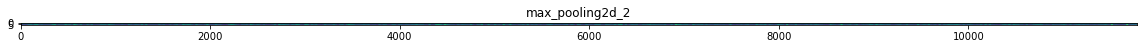

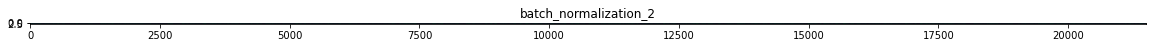

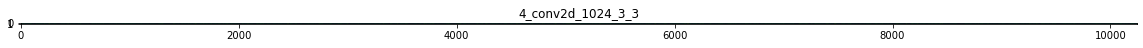

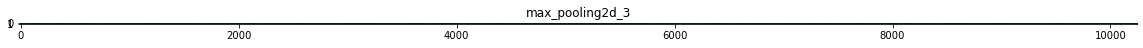

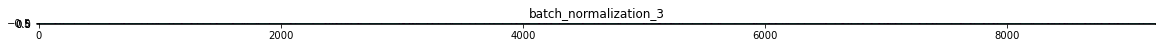

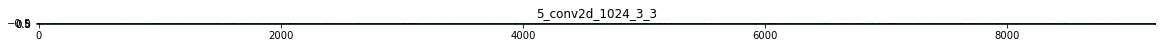

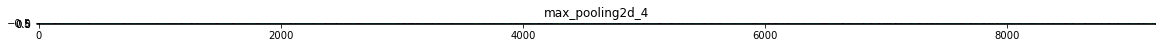

In [16]:
x   = img_to_array(img)                           # Numpy array with shape (150, 150, 3)
x   = x.reshape((1,) + x.shape)                   # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]
    size_y     = feature_map.shape[ 2]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size_y * n_features))
    #print("size: ",size,"  size * n_features:",size_y * n_features)
    #print("display_grid.shape: ",display_grid.shape)
    #print("display_grid.shape[0]: ",display_grid.shape[0])
    #print("display_grid.shape[1]: ",display_grid.shape[1])
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    #print("number of features: ", n_features)
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      
      xx = i * size
      yy = (i + 1) * size_y
      #print("xx: ", xx, "  yy: ",yy, "  x: ",x.shape)
      display_grid[:, i * size_y : (i + 1) * size_y] = x # Tile each filter into a horizontal grid

    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 
    